<a href="https://colab.research.google.com/github/alexwucpu05/NLP/blob/main/DILI_NER_SentClassification_FDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set environment

## 1.1. install packages

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 32.6 MB/s 
     |████████████████████████████████| 895 kB 33.2 MB/s 
     |████████████████████████████████| 3.3 MB 13.9 MB/s 
     |████████████████████████████████| 61 kB 215 kB/s 


In [ ]:
!pip install seqeval -q

     |████████████████████████████████| 43 kB 1.0 MB/s 


In [ ]:
!pip install shap -q

     |████████████████████████████████| 564 kB 5.5 MB/s 


In [ ]:
# !pip install nlp

## 1.2. set GPU device

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1.3. mount google drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1.4. load library

In [ ]:
import numpy as np
import pandas as pd
import transformers
import re
import os
import string
import pickle
import json
import joblib
from tqdm import tqdm, trange
import time
import datetime
import random
import codecs

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
# import spacy

from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import BertForTokenClassification, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import matthews_corrcoef, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score
from seqeval.metrics import f1_score, classification_report
from seqeval.metrics import accuracy_score as acc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2. Prepare data

## 2.1. set hyperparameters

In [ ]:
# Defining some key variables that will be used later on in the training
# USE_GPU = True

MAX_LEN = 128
BATCH_SIZE = 32
N_EPOCHS = 4
LEARNING_RATE = 2e-05
EPS = 1e-8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
WEIGHT_DECAY = False
SEED_VAL = 97

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 2.2. set helper functions

In [ ]:
keywords_positive = ['AST', 'ALT', 'ALP', 'transaminase', 'aminotransferase', 'alkaline phosphatase', 'bilirubin', 'liver', 'hepatic', 'hepato', 'hepatotoxicity', 'hepatitis', 'jaundice', 'cholestasis', 'cholestatic', 'steatosis', 'hepatomegaly', 'veno-occlusive', 'liver encephalopathy', 'hepatic encephalopathy']
keywords_negative = ['mice', 'mouse', 'rat', 'dog', 'animal', 'deliver', 'delivery']

In [ ]:
def normalize_text(text):
  text_norm = str(text).lower() # lower case
  url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
  # in sequential order
  text_norm = re.sub(r"\n", " ", text_norm) # remove \n
  text_norm = re.sub(r"\xa0", " ", text_norm) # remove \xa0
  text_norm = re.sub(url_regex, "<URL>", text_norm) # replace URL
  text_norm = re.sub("e.g. |e.g., ", "", text_norm) # remove "e.g."
  text_norm = re.sub(" etc.|, etc.", "", text_norm) # remove "etc."
  text_norm = re.sub(r"\(\d+\.\d+\)|\(\s\d+\.\d+\s\)", "", text_norm) # remove brackets contain only section index, e.g. (5.2)
  text_norm = re.sub(r"\(see.*?\)|\(\ssee.*?\)", "", text_norm) # remove cross-ref e.g. (see WARNINGS AND PRECAUTIONs 5.1)
  text_norm = re.sub(r"\[(see.*?)\]|\[\s(see.*?)\]", "", text_norm) # remove cross-ref e.g. [see WARNINGS AND PRECAUTIONs 5.1]
  text_norm = re.sub(r"(\t)\1+", " ", text_norm) # remove duplicated tab
  text_norm = re.sub(r"( )\1+", r"\1", text_norm) # remove duplicated white space
  return text_norm

In [ ]:
def lowercase_text(text):
  text_norm = str(text).lower() # lower case
  url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
  # in sequential order
  text_norm = re.sub(r"\n", " ", text_norm) # remove \n
  text_norm = re.sub(r"\xa0", " ", text_norm) # remove \xa0
  text_norm = re.sub(r"(\t)\1+", " ", text_norm) # remove duplicated tab
  text_norm = re.sub(r"( )\1+", r"\1", text_norm) # remove duplicated white space
  return text_norm

In [ ]:
# # Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#   pred_flat = np.argmax(preds, axis=1).flatten()
#   labels_flat = labels.flatten()
#   return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to flatten the pred labels
def flat_y_pred(preds):
  pred_flat = np.argmax(preds, axis=1).flatten()
  return pred_flat

# Function to flatten the true labels
def flat_y_true(true):
  true_flat = true.flatten()
  return true_flat

def get_scores(tn, fp, fn, tp):
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  PPV = tp/(tp+fp)
  NPV = tn/(tn+fn)
  return sensitivity, specificity, PPV, NPV

In [ ]:
def list_3d_flatten(labels_3d):
    labels_2d = []
    for batch in labels_3d:
        for sent in batch:
            labels_2d.append(sent)
    return labels_2d

In [ ]:
def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_tokenized_tags(sentence, tags):
    tokenized_sentence = []
    tokenized_labels = []

    words = sentence.split(" ")
    for word, label in zip(words, tags):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
        # Add the same label to the new list of labels `n_subwords` times
        tokenized_labels.extend([label] * n_subwords)
    
    return tokenized_sentence, tokenized_labels

In [ ]:
def pad_tokenized_tags(tags, max_len):
    if len(tags) <= max_len:
      tags.extend([tag_dict['B-padding']] * (max_len - len(tags)))
    else:
      tags = tags[0:max_len]
    return tags

In [ ]:
def remove_padding(label_ids, logits):
    y_true = [[label for label in flat_y_true(sent) if label != tag_dict['padding']] for sent in label_ids]
    y_pred_padded = [[label for label in flat_y_pred(sent)] for sent in logits]
    y_pred = []
    for idx, label in enumerate(y_pred_padded):
        y_pred.append(label[0:len(y_true[idx])])
    return y_true, y_pred

In [ ]:
def convert_tokenized_tags_to_original_length(tokenized_sents, tags):
   r = []
   r_tags = []
   for index, token in enumerate(tokenized_sents):
       if token.startswith("##"):
           if r:
               r[-1] = f"{r[-1]}{token[2:]}"
       else:
           r.append(token)
           r_tags.append(tags[index])
   return r, r_tags

In [ ]:
def map_labels_to_tags(true_labels, pred_labels):
    true_tags = [[tag_dict_reverse.get(label) for label in sent] for sent in list_3d_flatten(true_labels)]
    pred_tags = [[tag_dict_reverse.get(label) for label in sent] for sent in list_3d_flatten(pred_labels)]
    return true_tags, pred_tags

In [ ]:
class score_getter:
    def __init__(self, y_true, y_pred):
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(y_true, y_pred).ravel()
        self.sensitivity = self.tp/(self.tp+self.fn)
        self.specificity = self.tn/(self.tn+self.fp)
        self.PPV = self.tp/(self.tp+self.fp)
        self.NPV = self.tn/(self.tn+self.fn)
        self.f1 = 2*self.tp/(2*self.tp + self.fp + self.fn)
        self.auc = roc_auc_score(y_true, y_pred)
        self.acc = accuracy_score(y_true, y_pred)
        self.acc_bal = balanced_accuracy_score(y_true, y_pred)
        self.mcc = matthews_corrcoef(y_true, y_pred)
        

In [ ]:
def make_heatmap(y_true, y_pred, fig_name, categories, figsize=(15,12), fontsize=40, annot=True, fmt="d",cmap=ListedColormap(['lightskyblue']), 
                 cbar=False, linewidths=5, annot_kws={"size":100}):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cf = np.array([[tn, fn],
                   [fp, tp]])
    
    box_labels = [str(number) for number in cf.ravel()]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    hm = sns.heatmap(cf,annot=annot,fmt=fmt,cmap=cmap, cbar=cbar, linewidths=5, annot_kws=annot_kws)
    hm.invert_xaxis()
    hm.invert_yaxis()
    hm.xaxis.tick_top() # x axis on top
    hm.xaxis.set_label_position('top')
    plt.ylabel('Prediction condition', size=fontsize)
    plt.xlabel('True condition', size=fontsize)
    plt.xticks(size=fontsize*0.75)
    plt.yticks(size=fontsize*0.75)
    plt.savefig(f'{fig_name}.png')              
    plt.show()

## 2.3. load table 

In [ ]:
# set path to directory containing the pdf files for text mining
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/FDA_labels/'

# filename_test = 'test_doc_multiclass_20200830.pkl'
filename_test = 'FDA_label_train_test_doc_checked_trimmed_20210215.xlsx'

filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="Sheet1")
# test = pd.read_excel(filepath, sheet_name="test_set")

In [ ]:
test['Boxed_Warning'] = test['Boxed_Warning'].apply(normalize_text)
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
test['Adverse_Reactions'] = test['Adverse_Reactions'].apply(normalize_text)
test.head()

,LTKBID,Compound_name,LabelSection,vDILIConcern,Boxed_Warning,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_EMA_training
0,LT00003,mercaptopurine,Warnings and precautions,vMost-DILI-Concern,nan,"the most consistent, dose-related adverse rea...",6 adverse reactions the following clinically ...,0,1,1,2,2,1
1,LT00006,azathioprine,Warnings and precautions,vMost-DILI-Concern,"chronic immunosuppression with azathioprine, ...",malignancy patients receiving immunosuppressa...,adverse reactions the principal and potential...,1,1,1,2,2,1
2,LT00016,estradiol,Adverse reactions,vLess-DILI-Concern,estrogens increase the risk of endometrial ca...,see boxed warnings. estrogen and estrogen/pro...,"adverse reactions see boxed warnings , warnin...",0,0,0,1,1,1
3,LT00018,fluoxetine,Adverse reactions,vLess-DILI-Concern,warning: suicidal thoughts and behaviors see ...,"patients with mdd, both adult and pediatric, ...",6 adverse reactions the following adverse rea...,0,0,1,1,2,1
4,LT00020,gemfibrozil,Warnings and precautions,vMost-DILI-Concern,nan,"1. because of chemical, pharmacological, and ...",adverse reactions in the double-blind control...,0,1,1,2,2,1


## 2.4. check sentence length

In [ ]:
train = test[test.Test_set == 0]
val = test[test.Test_set == 1]
print(len(train), len(val))

600 150


In [ ]:
def get_number_of_sentences(documents):
    liver_sentences = []
    liver_negative_sentences = []
    for doc in tqdm(documents.Warnings_Precautions):
        sent_tokens = sent_tokenize(doc)
        for sent in sent_tokens:
            # KW context prediction
            kw_positive = any(keyword in sent for keyword in keywords_positive)
            kw_negative = any(keyword in sent for keyword in keywords_negative)
            if kw_positive == True and kw_negative == False:
                liver_sentences.append(sent) 
            else:
                liver_negative_sentences.append(sent)
    
    return len(list(set(liver_sentences))), len(list(set(liver_negative_sentences)))
    # return len(liver_sentences), len(liver_negative_sentences)

### FDA labels

In [ ]:
n_pos_t, n_neg_t = get_number_of_sentences(train)
n_pos_v, n_neg_v = get_number_of_sentences(val)

100%|██████████| 150/150 [00:00<00:00, 379.99it/s]


In [ ]:
# with duplicates
print(f"liver positive: {n_pos_t}")
print(f"liver positive: {n_neg_t}")
print(f"training sentences: {n_pos_t+n_neg_t}")
print(f"liver positive: {n_pos_v}")
print(f"liver positive: {n_neg_v}")
print(f"val sentences: {n_pos_v+n_neg_v}")

liver positive: 1778
liver positive: 34839
training sentences: 36617
liver positive: 435
liver positive: 8763
val sentences: 9198


In [ ]:
# deduplicated
print(f"liver positive: {n_pos_t}")
print(f"liver positive: {n_neg_t}")
print(f"training sentences: {n_pos_t+n_neg_t}")
print(f"liver positive: {n_pos_v}")
print(f"liver positive: {n_neg_v}")
print(f"val sentences: {n_pos_v+n_neg_v}")

liver positive: 1501
liver positive: 28054
training sentences: 29555
liver positive: 391
liver positive: 7433
val sentences: 7824


### EMA labels

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/EMA_labels/'
filename_test = 'EMA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="Sheet1")
# test = pd.read_excel(filepath, sheet_name="test_set")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
test['Adverse_Reactions'] = test['Adverse_Reactions'].apply(normalize_text)
print(len(test))
test.head()

540


,LTKBID,eMC_LabelSection2,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_FDA_training
0,LT00003,Warnings and precautions,6-mercaptopurine is an active cytotoxic agent ...,summary of the safety profile for 6-mercaptopu...,0,1,1,2,2,1
1,LT00016,Adverse reactions,• for the treatment of postmenopausal symptoms...,the following undesirable effects have been re...,0,0,0,1,1,1
2,LT00018,Adverse reactions,paediatric population - children and adolescen...,a. summary of the safety profile the most comm...,0,0,1,1,2,1
3,LT00020,Warnings and precautions,muscle disorders (myopathy/rhabdomyolysis) the...,most commonly reported adverse reactions are o...,0,0,0,1,1,1
4,LT00022,Warnings and precautions,indometacin may have a reversible inhibitory e...,"cns reactions - headaches, dizziness, light-he...",0,0,0,1,1,1


In [ ]:
train = test[test.Test_set == 0]
val = test[test.Test_set == 1]
print(len(train), len(val))

431 109


In [ ]:
n_pos_t, n_neg_t = get_number_of_sentences(train)
n_pos_v, n_neg_v = get_number_of_sentences(val)

100%|██████████| 109/109 [00:00<00:00, 595.09it/s]


In [ ]:
# with duplicates
print(f"liver positive: {n_pos_t}")
print(f"liver positive: {n_neg_t}")
print(f"training sentences: {n_pos_t+n_neg_t}")
print(f"liver positive: {n_pos_v}")
print(f"liver positive: {n_neg_v}")
print(f"val sentences: {n_pos_v+n_neg_v}")

liver positive: 1035
liver positive: 15285
training sentences: 16320
liver positive: 261
liver positive: 3943
val sentences: 4204


In [ ]:
# deduplicated
print(f"liver positive: {n_pos_t}")
print(f"liver positive: {n_neg_t}")
print(f"training sentences: {n_pos_t+n_neg_t}")
print(f"liver positive: {n_pos_v}")
print(f"liver positive: {n_neg_v}")
print(f"val sentences: {n_pos_v+n_neg_v}")

liver positive: 996
liver positive: 14108
training sentences: 15104
liver positive: 257
liver positive: 3787
val sentences: 4044


In [ ]:
sentences = []
liver_negative_sentences = []
for doc in tqdm(train.Warnings_Precautions):
    sent_tokens = sent_tokenize(doc)
    for sent in sent_tokens:
        sentences.append(sent_tokens)
        kw_positive = any(keyword in sent for keyword in keywords_positive)
        if kw_positive == False:
            liver_negative_sentences.append(sent)      
        
df_liver_negative_sentences = pd.DataFrame({'Liver_negative_sentences': liver_negative_sentences,
                                            'Label': [0]*len(liver_negative_sentences) }, 
                                            columns=['Liver_negative_sentences', 'Label'])

100%|██████████| 600/600 [00:01<00:00, 322.52it/s]


In [ ]:
df_liver_negative_sentences = shuffle(df_liver_negative_sentences)
df_liver_negative_sentences.drop_duplicates(inplace=True)
df_liver_negative_sentences.head()

,Liver_negative_sentences,Label
20475,fibrates increase the risk of myositis or myop...,0
25627,a median weight gain of 0.5 kg was observed in...,0
31123,fibrotic complications: see warnings: fibrotic...,0
32687,malignancies : stelara ® may increase risk of ...,0
9694,"because of a potential drug-drug interaction, ...",0


In [ ]:
df_liver_negative_sentences.shape

(27578, 2)

In [ ]:
# df_liver_negative_sentences.to_pickle(dirpath_test + 'liver_negative_sentences.pkl')
df_liver_negative_sentences = pd.read_pickle(dirpath_test + 'liver_negative_sentences.pkl')

In [ ]:
for i in range(int(df_liver_negative_sentences.shape[0]/5000) + 1):
    fn = f"df_liver_negative_sentences_{i}.txt"
    if (i+1)*5000 < df_liver_negative_sentences.shape[0]:
        with codecs.open(dirpath_test + fn, "w", "utf8") as outfile:
            outfile.write("\n".join(str(s) for s in df_liver_negative_sentences['Liver_negative_sentences'][i*5000:(i+1)*5000]))
    else:
        with codecs.open(dirpath_test + fn, "w", "utf8") as outfile:
            outfile.write("\n".join(str(s) for s in df_liver_negative_sentences['Liver_negative_sentences'][i*5000:]))

In [ ]:
# for i in range(int(34012/5000) + 1):
#     fn = f"df_liver_negative_sentences_{i}.txt"
#     if (i+1)*5000 < 34012:
#         print(df_liver_negative_sentences['Liver_negative_sentences'][i*5000:(i+1)*5000].head())
#     else:
#         print(df_liver_negative_sentences['Liver_negative_sentences'][i*5000:].head())

In [ ]:
def check_sent_length(sentences, tokenizer):
    input_ids = []
    length = []
    max_len = 0

    # For every sentence...
    for sent in sentences:
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        encoded_sent = tokenizer.encode(sent, add_special_tokens=True)

        # update the input_ids
        input_ids.append(encoded_sent)
        # Update the sentence length.
        length.append(len(encoded_sent))
        # Update the maximum sentence length.
        max_len = max(max_len, len(encoded_sent))

    print('Max sentence length: ', max_len)
    return length, max_len

In [ ]:
length, max_len = check_sent_length(sentences, tokenizer)

Max sentence length:  220


In [ ]:
print(len(length))
print(len([i for i in length if i > 64]))
print(len([i for i in length if i > 128]))

45815
29814
9220


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


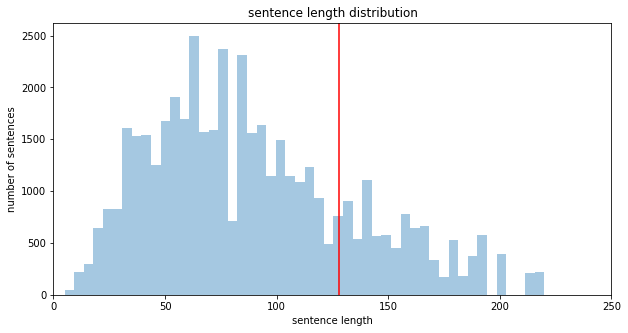

In [ ]:
# plot distribution 
plt.figure(figsize=(10,5))
sns.distplot(length, kde=False, rug=False)
sns.set_style('darkgrid')
plt.title('sentence length distribution')
plt.xlabel('sentence length')
plt.xlim(0, 250)
plt.ylabel('number of sentences')
plt.axvline(128, color='red')

## 2.5. get train/test doc set

In [ ]:
train_doc = test[test.Test_set == 0]['Warnings_Precautions'].values
train_label = test[test.Test_set == 0]['WP_true_label_updated'].values

In [ ]:
test_doc = test[test.Test_set == 1]['Warnings_Precautions'].values
test_label = test[test.Test_set == 1]['WP_true_label_updated'].values

In [ ]:
train_sents = [sent for sent in sent_tokenize(train_doc[0])]

In [ ]:
print(train_sents[3])

tpmt genotyping or phenotyping (red blood cell tpmt activity) and nudt15 genotyping can identify patients who have reduced activity of these enzymes.


In [ ]:
example_sent = 'the pattern of liver damage was predominantly hepatocellular.'
# example_sent = 'caution should be exercised when treating patients with severe hepatic impairment.'
# example_sent = 'hepatic failure has been reported.'

# 3. Load models

## 3.1. load tokenizer

In [ ]:
# load tokenizer from a trained model
tokenizer = BertTokenizer.from_pretrained('/content/gdrive/My Drive/NLP/NER/model_save/NER_FDA_bs32_epoch4_20210304_170545/', do_lower_case=True)


HTTPError: ignored

## 3.2. NER model for context determination

### FDA NER model

In [ ]:
# load the trained NER model 
model_NER = BertForTokenClassification.from_pretrained('/content/gdrive/My Drive/NLP/NER/model_save/NER_FDA_bs32_epoch4_20210325_145016/')

# Copy the model to the GPU.
model_NER.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### EMA NER model

In [ ]:
model_NER = BertForTokenClassification.from_pretrained('/content/gdrive/My Drive/NLP/NER/model_save/NER_EMA_bs32_epoch4_20210325_164534/')
# Copy the model to the GPU.
model_NER.to(device)

## 3.3. Sentence classification models

### FDA model

In [ ]:
# load the trained FDA sentence classification model 
model_SentClf = BertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/DILI_BERT/model_save/BERT_SentClass_bs16_epoch3_20200902_062203/')
# Copy the model to the GPU.
model_SentClf.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### EMA model

In [ ]:
model_SentClf = BertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/DILI_BERT/model_save/EMA_BERT_SentClass_bs16_epoch3_20201019_070107/')
# Copy the model to the GPU.
model_SentClf.to(device)

# 4. Model inference

## 4.1. define inference functions

In [ ]:
def model_NER_predict_single_sentence(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=False, max_length=512, truncation=True)
    inputs = inputs.to(device)
    # Set to evaluation mode
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    y_pred = np.argmax(logits, axis=2).flatten()
    # y_pred_sent = [1 if (1 in y_pred) | (0 in y_pred) else 0]
    y_pred_sent = [1 if 0 in y_pred else 0]
    return y_pred_sent

In [ ]:
def model_SentClf_predict_single_sentence(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", max_length=MAX_LEN, truncation=True)
    inputs = inputs.to(device)
    # Set to evaluation mode
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    y_pred = np.argmax(logits, axis=1).flatten()
    return y_pred

In [ ]:
def sentence_encoder(sentences, tokenizer, max_len):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,
                            padding = 'max_length',
                            truncation = True,
                            return_attention_mask = True,
                            return_tensors = 'pt', 
                      )  
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [ ]:
def model_SentClf_predict_batch(sentences, tokenizer, model):
    # encode sentences
    input_ids, attention_masks = sentence_encoder(sentences, tokenizer, MAX_LEN)
    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)
    # model prediction
    pred_labels = []

    model.eval()

    for batch in prediction_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs['logits']
        logits = logits.detach().cpu().numpy()
        pred_labels.append(flat_y_pred(logits))

    sent_labels = np.concatenate(pred_labels, axis=0)
    return sent_labels

In [ ]:
def doc_Clf(documents):
    doc_labels = []
    for doc in tqdm(documents):
        sentences = sent_tokenize(doc)
        sent_labels = [0] * len(sentences)
        # context prediction and get liver sentence indexes
        liver_sent_idx = []
        for idx, sentence in enumerate(sentences):
            context_pred = model_NER_predict_single_sentence(sentence, tokenizer, model_NER)
            if context_pred[0] == 1:
                liver_sent_idx.append(idx)
        # sentence prediction for liver sentences (if any)
        if liver_sent_idx:
            liver_sentences = [sentences[i] for i in liver_sent_idx]
            liver_sent_labels = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
            for i, l in enumerate(liver_sent_labels):
                if l == 1:
                    sent_labels[liver_sent_idx[i]] = 1

        doc_label = [1 if np.sum(sent_labels) > 0 else 0]
        doc_labels.append(doc_label[0])
    return doc_labels

In [ ]:
def doc_Clf_sent_direct(documents):
    doc_labels = []
    sents_positive = []
    for doc in tqdm(documents):
        sentences = sent_tokenize(doc)
        sent_labels = model_SentClf_predict_batch(sentences, tokenizer, model_SentClf)
        doc_label = [1 if np.sum(sent_labels) > 0 else 0]
        doc_labels.append(doc_label[0])

        for idx, label in enumerate(sent_labels):
            if label == 1:
                sents_positive.append(sentences[idx])
    return doc_labels

In [ ]:
def doc_Clf_HybridAI(documents):
    doc_labels = []
    for doc in tqdm(documents):
        # prepare sentences
        liver_sentences = []
        # tokenize liver-related sentences
        sent_tokens = sent_tokenize(doc)
        for sent in sent_tokens:
            kw_positive = any(keyword in word_tokenize(sent) for keyword in keywords_positive)
            kw_negative = any(keyword in word_tokenize(sent) for keyword in keywords_negative)
            if kw_positive == True and kw_negative == False:
                liver_sentences.append(sent)  

        if len(liver_sentences) == 0:
            doc_label = [0]
        else:
            liver_sent_labels = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
            doc_label = [1 if np.sum(liver_sent_labels) > 0 else 0]
   
        doc_labels.append(doc_label[0])
    return doc_labels

In [ ]:
def doc_Clf_KWs(documents):
    doc_labels = []
    # define keywords
    keywords_DILI = ['veno-occlusive', 'sgpt', 'sgot', 'alanine aminotransferase', 'aspartate aminotransferase', 'alkaline phosphatase', 'liver enzyme', 'bilirubinemia', 'bilirubin',
                'jaundice', 'fatty liver', 'steatosis', 'steatohepatitis', 'hepatocellular', 'Cholestatic', 'Cholestatic hepatitis', 'eosinophilic hepatitis', 
                'cholestasis', 'hepatopathy', 'hepatomegaly', 'liver necrosis', 'hepatic necrosis', 'liver failure', 'hepatic abnormalities',
                'hepatic failure', 'liver dysfunction', 'hepatic dysfunction', 'liver encephalopathy', 'hepatic encephalopathy', 'liver transplantation', 
                'hepatic transplantation', 'hepatotoxicity', 'liver toxicity', 'hepatic toxicity', 'liver injury', 'hepatic injury', 
                'liver reaction', 'hepatic reaction', 'liver function', 'hepatic function', 'biliary colic', 'hepatobiliary',
                'increases in aspartate', 'increases in alanine', 'increases in alkaline', 'increases in ast', 'increases in alt', 'increases in alp',
                'abnormalities of alt', 'abnormalities of ast', 'abnormalities of alp', 'abnormalities of alanine', 'abnormalities of aspartate', 'abnormalities of alkaline',
                'increased ast', 'increased alt', 'increased alp', 'increased alanine', 'increased aspartate', 'increased alkaline', 
                'alt abnormalities', 'ast abnormalities', 'alp abnormalities', 'alt elevation', 'ast elevation', 'alp elevation', 'alt increase', 'ast increase', 'alp increase',
                'serum levels of transaminase', 'serum transaminase', 'alanine transaminase', 'aspartate transaminase', 'hepatic transaminases',
                'abnormalities of transaminase', 'transaminases abnormal', 'increases in transaminase','increased transaminase', 'transaminases increase', 
                'hepatic enzyme elevation', 'elevated transaminase', 'elevations of transaminase', 'elevation of transaminase', 'transaminase elevation', 'hepatic enzyme', 'liver enzyme', 
                'hepatitis'
                #    'hepatitis,', ', hepatitis', 'hepatitis.'
                    ]
    # for each title
    for doc in tqdm(documents):
        doc_pred_label = int(any(keyword in str(doc) for keyword in keywords_DILI))
        doc_labels.append(doc_pred_label)
    return doc_labels

## 4.2. FDA model predicts FDA test doc set

### load table

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/FDA_labels/'
filename_test = 'FDA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="test_set")
test['Boxed_Warning'] = test['Boxed_Warning'].apply(normalize_text)
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
test['Adverse_Reactions'] = test['Adverse_Reactions'].apply(normalize_text)
print(len(test))
test.head()

150


,LTKBID,Compound_name,LabelSection,vDILIConcern,Boxed_Warning,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_EMA_training
0,LT00006,azathioprine,Warnings and precautions,vMost-DILI-Concern,"chronic immunosuppression with azathioprine, ...",malignancy patients receiving immunosuppressa...,adverse reactions the principal and potential...,1,1,1,2,2,1
1,LT00056,bicalutamide,Warnings and precautions,vMost-DILI-Concern,nan,cases of death or hospitalization due to seve...,6 adverse reactions adverse reactions that oc...,1,1,1,2,2,1
2,LT00107,imatinib,Warnings and precautions,vMost-DILI-Concern,nan,imatinib mesylate is often associated with ed...,6 adverse reactions the following serious adv...,1,1,1,2,2,1
3,LT00119,metformin,no mentioned,vLess-DILI-Concern,warning: lactic acidosis postmarketing cases ...,• lactic acidosis: see boxed warning. • vitam...,6 adverse reactions the following adverse rea...,1,0,1,1,2,1
4,LT00121,methyldopa,Warnings and precautions,vMost-DILI-Concern,nan,it is important to recognize that a positive ...,"adverse reactions sedation, usually transient...",1,1,1,2,2,1


In [ ]:
test_doc = test.Warnings_Precautions.values
test_label = test.WP_true_label_updated.values

### model prediction

#### AI model

In [ ]:
doc_pred_labels = doc_Clf(test_doc[0:2])

100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


In [ ]:
test['WP_NER_pred_label'] = doc_pred_labels

In [ ]:
# test.to_excel(dirpath_test + 'FDA_NERcontext_test_doc_checked_20210311.xlsx')
test.to_excel(dirpath_test + 'FDA_NERcontext_test_doc_checked_all_20210325.xlsx')

In [ ]:
print(len(test_doc))
print(len(doc_pred_labels))

In [ ]:
print(doc_pred_labels)

In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)

print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:40, TN:99, FP:11, FN:0
sensitivity:1.000, specificity:0.900, PPV:0.784, NPV:1.000, F1:0.879
ACC:0.927, ACC_bal:0.950, MCC:0.840
AUC:0.950


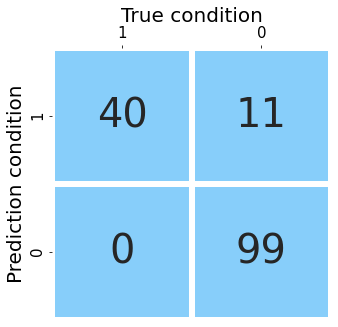

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

#### Hybrid AI model

In [ ]:
test = pd.read_excel(os.path.join(dirpath_test, 'FDA_NERcontext_test_doc_checked_all_20210325.xlsx'))
print(len(test))
test.head()

150


,Unnamed: 0,LTKBID,Compound_name,LabelSection,vDILIConcern,Boxed_Warning,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_EMA_training,WP_NER_pred_label
0,0,LT00006,azathioprine,Warnings and precautions,vMost-DILI-Concern,"chronic immunosuppression with azathioprine, ...",malignancy patients receiving immunosuppressa...,adverse reactions the principal and potential...,1,1,1,2,2,1,1
1,1,LT00056,bicalutamide,Warnings and precautions,vMost-DILI-Concern,NaN,cases of death or hospitalization due to seve...,6 adverse reactions adverse reactions that oc...,1,1,1,2,2,1,1
2,2,LT00107,imatinib,Warnings and precautions,vMost-DILI-Concern,NaN,imatinib mesylate is often associated with ed...,6 adverse reactions the following serious adv...,1,1,1,2,2,1,1
3,3,LT00119,metformin,no mentioned,vLess-DILI-Concern,warning: lactic acidosis postmarketing cases ...,• lactic acidosis: see boxed warning. • vitam...,6 adverse reactions the following adverse rea...,1,0,1,1,2,1,1
4,4,LT00121,methyldopa,Warnings and precautions,vMost-DILI-Concern,NaN,it is important to recognize that a positive ...,"adverse reactions sedation, usually transient...",1,1,1,2,2,1,1


In [ ]:
test_doc = test.Warnings_Precautions.to_list()
test_label = test.WP_true_label_updated.values

In [ ]:
doc_pred_labels = doc_Clf_HybridAI(test_doc)

100%|██████████| 150/150 [00:54<00:00,  2.74it/s]


In [ ]:
len(doc_pred_labels)

150

In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:39, TN:103, FP:7, FN:1
sensitivity:0.975, specificity:0.936, PPV:0.848, NPV:0.990, F1:0.907
ACC:0.947, ACC_bal:0.956, MCC:0.874
AUC:0.956


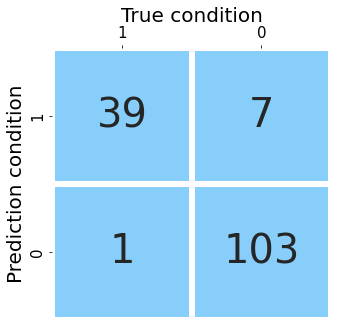

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

In [ ]:
test['WP_hybrid_pred_label'] = doc_pred_labels

In [ ]:
test.to_excel(os.path.join(dirpath_test, 'FDA_NERcontext_test_doc_checked_all_20210930.xlsx'))

### get scores

In [ ]:
balanced_accuracy_score(test_label, doc_pred_labels)

0.9136363636363636

In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)

In [ ]:
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:40, TN:91, FP:19, FN:0
sensitivity:1.000, specificity:0.827, PPV:0.678, NPV:1.000, F1:0.808
ACC:0.873, ACC_bal:0.914, MCC:0.749
AUC:0.914


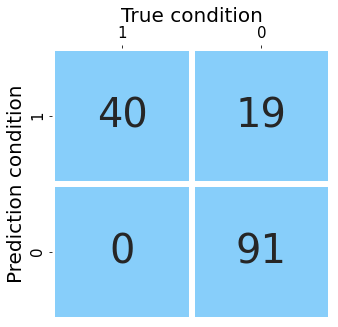

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

### analysis

In [ ]:
def get_NER_liver_sentences(doc):
    liver_sentences, liver_sentences_idx = [], []
    sentences = sent_tokenize(doc)
    for idx, sent in enumerate(sentences):
        context_pred = model_NER_predict_single_sentence(sent, tokenizer, model_NER)
        if context_pred[0] == 1:
            liver_sentences_idx.append(idx)
            liver_sentences.append(sent)
    df_liver_sent = pd.DataFrame({
        'index':liver_sentences_idx,
        'liver_sentences':liver_sentences,
    },
        columns=['index', 'liver_sentences'])
    return df_liver_sent

In [ ]:
def get_KW_liver_sentences(doc):
    liver_sentences, liver_sentences_idx = [], []
    sentences = sent_tokenize(doc)
    for idx, sent in enumerate(sentences):
        kw_positive = any(keyword in sent for keyword in keywords_positive)
        kw_negative = any(keyword in sent for keyword in keywords_negative)
        if kw_positive == True and kw_negative == False:
            liver_sentences_idx.append(idx)
            liver_sentences.append(sent) 
    df_liver_sent = pd.DataFrame({
        'index':liver_sentences_idx,
        'liver_sentences':liver_sentences,
    },
        columns=['index', 'liver_sentences'])
    return df_liver_sent

In [ ]:
def compare_sent_pred_NER_KW(ner_sentences, kw_sentences):
    y_ner, y_kw = [], []
    for sentence in ner_sentences:
        l_ner = model_SentClf_predict_single_sentence(sentence, tokenizer, model_SentClf)
        y_ner.append(l_ner[0])
    for sentence in kw_sentences:
        l_kw = model_SentClf_predict_single_sentence(sentence, tokenizer, model_SentClf)
        y_kw.append(l_kw[0])
    return y_ner, y_kw

In [ ]:
doc_id = 22

df_KW = get_KW_liver_sentences(test_doc[doc_id])
df_NER = get_NER_liver_sentences(test_doc[doc_id])

In [ ]:
df_NER

,index,liver_sentences
0,11,"in addition, downward shifts within the ganire..."


In [ ]:
df_KW

,index,liver_sentences
0,11,"in addition, downward shifts within the ganire..."


In [ ]:
y_ner, y_kw = compare_sent_pred_NER_KW(df_NER.liver_sentences, df_KW.liver_sentences)
print(y_ner)
print(y_kw)

[1]
[1]


In [ ]:
df_NER.liver_sentences[1]

'at this dose, paclitaxel caused reduced fertility and reproductive indices, and increased embryo- and fetotoxicity.'

In [ ]:
def doc_Clf(documents):
    doc_labels = []
    for doc in tqdm(documents):
        sentences = sent_tokenize(doc)
        sent_labels = [0] * len(sentences)
        # context prediction and get liver sentence indexes
        liver_sent_idx = []
        for idx, sentence in enumerate(sentences):
            context_pred = model_NER_predict_single_sentence(sentence, tokenizer, model_NER)
            if context_pred[0] == 1:
                liver_sent_idx.append(idx)
        # sentence prediction for liver sentences (if any)
        if liver_sent_idx:
            liver_sentences = [sentences[i] for i in liver_sent_idx]
            liver_sent_labels = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
            for i, l in enumerate(liver_sent_labels):
                if l == 1:
                    sent_labels[liver_sent_idx[i]] = 1

        doc_label = [1 if np.sum(sent_labels) > 0 else 0]
        doc_labels.append(doc_label[0])
    return doc_labels

In [ ]:
doc_pred_labels = doc_Clf(test_doc[0:2])

100%|██████████| 2/2 [00:22<00:00, 11.14s/it]


In [ ]:
doc_pred_labels

[1, 1]

In [ ]:
doc_labels = []
for doc in tqdm(test_doc[1:2]):
    sentences = sent_tokenize(doc)
    sent_labels = [0] * len(sentences)
    # context prediction and get liver sentence indexes
    liver_sent_idx = []
    for idx, sentence in enumerate(sentences):
        context_pred = model_NER_predict_single_sentence(sentence, tokenizer, model_NER)
        if context_pred[0] == 1:
            liver_sent_idx.append(idx)
    # sentence prediction for liver sentences (if any)
    if liver_sent_idx:
        liver_sentences = [sentences[i] for i in liver_sent_idx]
        liver_sent_labels = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
        for i, l in enumerate(liver_sent_labels):
            if l == 1:
                sent_labels[liver_sent_idx[i]] = 1

    doc_label = [1 if np.sum(sent_labels) > 0 else 0]
    doc_labels.append(doc_label[0])

100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


In [ ]:
liver_sentences

[' cases of death or hospitalization due to severe liver injury (hepatic failure) have been reported post-marketing in association with the use of bicalutamide.',
 'hepatotoxicity in these reports generally occurred within the first three to four months of treatment.',
 'hepatitis or marked increases in liver enzymes leading to drug discontinuation occurred in approximately 1% of bicalutamide patients in controlled clinical trials.',
 'serum transaminase levels should be measured prior to starting treatment with bicalutamide, at regular intervals for the first four months of treatment, and periodically thereafter.',
 'if clinical symptoms or signs suggestive of liver dysfunction occur (nausea, vomiting, abdominal pain, fatigue, anorexia, "flu-like" symptoms, dark urine, jaundice, or right upper quadrant tenderness), the serum transaminases, in particular the serum alt, should be measured immediately.',
 'if at any time a patient has jaundice, or their alt rises above two times the uppe

In [ ]:
liver_sent_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def doc_Clf(documents):
    doc_labels = []
    for doc in tqdm(documents):
        sentences = sent_tokenize(doc)
        sent_labels = []
        # context prediction and get liver sentence indexes
        for sentence in sentences:
            context_pred = model_NER_predict_single_sentence(sentence, tokenizer, model_NER)
            if context_pred[0] == 0:
                lab_sent = [0]
                sent_labels.append(lab_sent[0])
            elif context_pred[0] == 1:
                # sentence prediction for liver sentences (if any)
                lab_sent = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
                sent_labels.append(lab_sent[0])
                
        doc_label = [1 if np.sum(sent_labels) > 0 else 0]
        doc_labels.append(doc_label[0])
    return doc_labels

In [ ]:
doc_pred_labels = doc_Clf(test_doc[0:2])

100%|██████████| 2/2 [01:03<00:00, 31.80s/it]


In [ ]:
doc_pred_labels

[1, 1]

## 4.3. FDA model predicts EMA test doc set

### load table

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/EMA_labels/'
filename_test = 'EMA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="not_in_FDA_training")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
test.head()

175


,LTKBID,eMC_LabelSection2,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_FDA_training
0,LT00046,Warnings and precautions,patients with rare hereditary problems of gala...,the following adverse reactions are classified...,0,1,1,2,2,0
1,LT00671,Warnings and precautions,careful monitoring during dronedarone administ...,summary of the safety profile assessment of in...,0,1,1,2,2,0
2,LT01525,Warnings and precautions,the selection of meropenem to treat an individ...,summary of the safety profile in a review of 4...,0,1,1,2,2,0
3,LT01097,Warnings and precautions,hypersensitivity caution should be used in pre...,summary of safety profile the safety profile o...,0,1,1,2,2,0
4,LT01181,Warnings and precautions,oxaliplatin should only be used in specialized...,summary of the safety profile the most frequen...,0,1,1,2,2,0


In [ ]:
test_doc = test.Warnings_Precautions.values
test_label = test.WP_true_label_updated.values

### model prediction

#### AI model

In [ ]:
doc_pred_labels = doc_Clf(test_doc)

100%|██████████| 175/175 [01:56<00:00,  1.51it/s]


In [ ]:
test_doc[93]

"hypersensitivity hypersensitivity reactions to mesna have been reported following administration of mesna as an uroprotectant. these include various skin and subcutaneous tissue symptoms . in addition, cases of severe bullous and ulcerative skin and mucosal reactions were reported. in some cases, skin reactions were accompanied by one or more other symptoms, such as fever, cardiovascular, pulmonary symptoms, haematological abnormalities, nausea, vomiting, pain in the extremities, arthralgia, myalgia, malaise and conjunctivitis . some reactions have presented as anaphylaxis. fever accompanied by, hypotension but no skin manifestations has also been reported. some patients with a history of a reaction have shown positive delayed-type skin test results. however, a negative delayed reaction does not exclude hypersensitivity to mesna. positive immediate-type skin test reactions have occurred in patients regardless of previous mesna exposure or history of hypersensitivity reactions, and may

In [ ]:
test['WP_NER_pred_label'] = doc_pred_labels
test.to_excel(dirpath_test + 'FDA_NERcontext_test_doc_checked_cross_agency_20210326.xlsx')

In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)

print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:36, TN:124, FP:15, FN:0
sensitivity:1.000, specificity:0.892, PPV:0.706, NPV:1.000, F1:0.828
ACC:0.914, ACC_bal:0.946, MCC:0.794
AUC:0.946


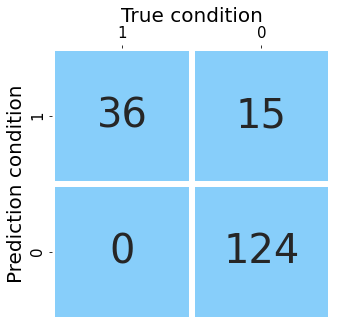

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

#### Hybrid AI model

In [ ]:
test = pd.read_excel(os.path.join(dirpath_test, 'FDA_NERcontext_test_doc_checked_cross_agency_20210326.xlsx'))
print(len(test))
test.head()

175


,Unnamed: 0,LTKBID,eMC_LabelSection2,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_FDA_training,WP_NER_pred_label
0,0,LT00046,Warnings and precautions,patients with rare hereditary problems of gala...,the following adverse reactions are classified...,0,1,1,2,2,0,1
1,1,LT00671,Warnings and precautions,careful monitoring during dronedarone administ...,summary of the safety profile assessment of in...,0,1,1,2,2,0,1
2,2,LT01525,Warnings and precautions,the selection of meropenem to treat an individ...,summary of the safety profile in a review of 4...,0,1,1,2,2,0,1
3,3,LT01097,Warnings and precautions,hypersensitivity caution should be used in pre...,summary of safety profile the safety profile o...,0,1,1,2,2,0,1
4,4,LT01181,Warnings and precautions,oxaliplatin should only be used in specialized...,summary of the safety profile the most frequen...,0,1,1,2,2,0,1


In [ ]:
test_doc = test.Warnings_Precautions.to_list()
test_label = test.WP_true_label_updated.values

In [ ]:
doc_pred_labels = doc_Clf_HybridAI(test_doc)

100%|██████████| 175/175 [00:41<00:00,  4.26it/s]


In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:35, TN:126, FP:13, FN:1
sensitivity:0.972, specificity:0.906, PPV:0.729, NPV:0.992, F1:0.833
ACC:0.920, ACC_bal:0.939, MCC:0.796
AUC:0.939


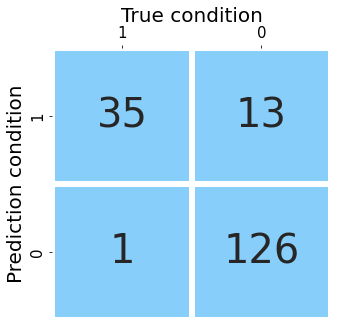

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

In [ ]:
test['WP_hybrid_pred_label'] = doc_pred_labels

In [ ]:
test.to_excel(os.path.join(dirpath_test, 'FDA_NERcontext_test_doc_checked_cross_agency_20210930.xlsx'))

## 4.4. Evaluate FDA NER model on FDA test set

### load table

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/FDA_labels/'
filename_test = 'FDA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="test_set")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
test.head()

150


,LTKBID,Compound_name,LabelSection,vDILIConcern,Boxed_Warning,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_EMA_training
0,LT00006,azathioprine,Warnings and precautions,vMost-DILI-Concern,"chronic immunosuppression with azathioprine, ...",malignancy patients receiving immunosuppressa...,adverse reactions the principal and potential...,1,1,1,2,2,1
1,LT00056,bicalutamide,Warnings and precautions,vMost-DILI-Concern,nan,cases of death or hospitalization due to seve...,6 adverse reactions adverse reactions that oc...,1,1,1,2,2,1
2,LT00107,imatinib,Warnings and precautions,vMost-DILI-Concern,nan,imatinib mesylate is often associated with ed...,6 adverse reactions the following serious adv...,1,1,1,2,2,1
3,LT00119,metformin,no mentioned,vLess-DILI-Concern,warning: lactic acidosis postmarketing cases ...,• lactic acidosis: see boxed warning. • vitam...,6 adverse reactions the following adverse rea...,1,0,1,1,2,1
4,LT00121,methyldopa,Warnings and precautions,vMost-DILI-Concern,nan,it is important to recognize that a positive ...,"adverse reactions sedation, usually transient...",1,1,1,2,2,1


### evaluation on test set

In [ ]:
def compare_liver_context_pred(documents):
    sentences = []
    liver_context_KW = []
    liver_context_NER = []

    for doc in tqdm(documents):
        sent_tokens = sent_tokenize(doc)
        for sent in sent_tokens:
            sentences.append(sent)
            # KW context prediction
            kw_positive = any(keyword in sent for keyword in keywords_positive)
            kw_negative = any(keyword in sent for keyword in keywords_negative)
            if kw_positive == True and kw_negative == False:
                kw_pred = 1
            else:
                kw_pred = 0
            liver_context_KW.append(kw_pred)      
            # NER context prediction
            ner_pred = model_NER_predict_single_sentence(sent, tokenizer, model_NER)
            liver_context_NER.append(ner_pred[0])      

    df_liver_contex_pred = pd.DataFrame({'Sentences': sentences,
                                         'Labels_KW': liver_context_KW,
                                         'Labels_NER': liver_context_NER
                                         }, 
                                        columns=['Sentences', 'Labels_KW', 'Labels_NER'])
    return df_liver_contex_pred

In [ ]:
df_liver_contex_compare = compare_liver_context_pred(test.Warnings_Precautions.values)

100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


In [ ]:
df_liver_contex_compare.to_excel(dirpath_test + 'df_liver_contex_compare_FDA_20210328.xlsx')

In [ ]:
df_liver_contex_compare.head()

,Sentences,Labels_KW,Labels_NER
0,malignancy patients receiving immunosuppressa...,0,0
1,physicians should inform patients of the risk ...,0,0
2,as usual for patients with increased risk for ...,0,0
3,post-transplant renal transplant patients are ...,0,0
4,the risk of post-transplant lymphomas may be i...,0,0


In [ ]:
print(f"liver positive sentences: {len(df_liver_contex_compare[df_liver_contex_compare.Labels_KW == 1])}")
print(f"liver negative sentences: {len(df_liver_contex_compare[df_liver_contex_compare.Labels_KW == 0])}")

liver positive sentences: 435
liver negative sentences: 8763


### get scores

In [ ]:
test_scores = score_getter(df_liver_contex_compare['Labels_KW'], df_liver_contex_compare['Labels_NER'])

In [ ]:
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:431, TN:8675, FP:88, FN:4
sensitivity:0.991, specificity:0.990, PPV:0.830, NPV:1.000, F1:0.904
ACC:0.990, ACC_bal:0.990, MCC:0.902
AUC:0.990


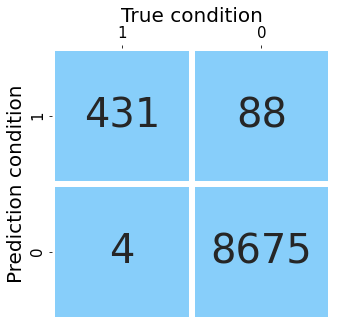

In [ ]:
make_heatmap(df_liver_contex_compare['Labels_KW'], df_liver_contex_compare['Labels_NER'], 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

## 4.5. Evaluate FDA NER model on EMA test set

### load table

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/EMA_labels/'
filename_test = 'EMA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="not_in_FDA_training")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
test.head()

175


,LTKBID,eMC_LabelSection2,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_FDA_training
0,LT00046,Warnings and precautions,patients with rare hereditary problems of gala...,the following adverse reactions are classified...,0,1,1,2,2,0
1,LT00671,Warnings and precautions,careful monitoring during dronedarone administ...,summary of the safety profile assessment of in...,0,1,1,2,2,0
2,LT01525,Warnings and precautions,the selection of meropenem to treat an individ...,summary of the safety profile in a review of 4...,0,1,1,2,2,0
3,LT01097,Warnings and precautions,hypersensitivity caution should be used in pre...,summary of safety profile the safety profile o...,0,1,1,2,2,0
4,LT01181,Warnings and precautions,oxaliplatin should only be used in specialized...,summary of the safety profile the most frequen...,0,1,1,2,2,0


In [ ]:
print(f"liver positive doc: {len(test[test.WP_true_label_updated == 1])}")
print(f"liver negative doc: {len(test[test.WP_true_label_updated == 0])}")

liver positive doc: 36
liver negative doc: 139


### evaluation on test set

In [ ]:
df_liver_contex_compare = compare_liver_context_pred(test.Warnings_Precautions.values)

100%|██████████| 175/175 [01:49<00:00,  1.60it/s]


In [ ]:
df_liver_contex_compare.to_excel(dirpath_test + 'df_liver_contex_compare_FDA_NER_cross_agency_20210328.xlsx')

In [ ]:
print(f"liver positive sentences: {len(df_liver_contex_compare[df_liver_contex_compare.Labels_KW == 1])}")
print(f"liver negative sentences: {len(df_liver_contex_compare[df_liver_contex_compare.Labels_KW == 0])}")

liver positive sentences: 341
liver negative sentences: 6115


### get scores

In [ ]:
test_scores = score_getter(df_liver_contex_compare['Labels_KW'], df_liver_contex_compare['Labels_NER'])

In [ ]:
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:334, TN:6036, FP:79, FN:7
sensitivity:0.979, specificity:0.987, PPV:0.809, NPV:0.999, F1:0.886
ACC:0.987, ACC_bal:0.983, MCC:0.883
AUC:0.983


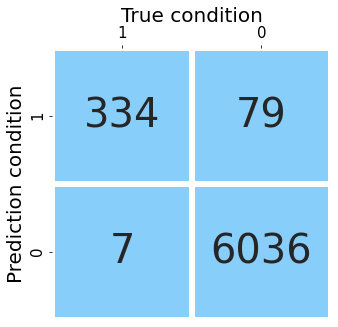

In [ ]:
make_heatmap(df_liver_contex_compare['Labels_KW'], df_liver_contex_compare['Labels_NER'], 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

# Appendix

## FDA NER model sentence count

### load table

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/FDA_labels/'
filename_test = 'FDA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

test = pd.read_excel(filepath, sheet_name="Sheet1")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
# test.head()

750


In [ ]:
train_doc = test[test.Test_set == 0].Warnings_Precautions.values
print(len(train_doc))

600


### predict context

In [ ]:
df_liver_contex_compare_train_doc = compare_liver_context_pred(train_doc)

100%|██████████| 600/600 [10:21<00:00,  1.04s/it]


In [ ]:
# df_liver_contex_compare_train_doc.to_excel(dirpath_test + 'df_liver_contex_compare_FDA_NER_train_doc_20210331.xlsx')
df_liver_contex_compare_train_doc = pd.read_excel(dirpath_test + 'df_liver_contex_compare_FDA_NER_train_doc_20210331.xlsx')

In [ ]:
print(f"liver sentences: {len(df_liver_contex_compare_train_doc[df_liver_contex_compare_train_doc.Labels_KW == 1])}")
print(f"non-liver sentences: {len(df_liver_contex_compare_train_doc[df_liver_contex_compare_train_doc.Labels_KW == 0])}")

liver sentences: 1778
non-liver sentences: 34839


In [ ]:
df_liver_contex_compare_train_doc_unique = df_liver_contex_compare_train_doc.drop_duplicates(subset=['Sentences'])

print(f"total: {len(df_liver_contex_compare_train_doc_unique)}")
print(f"KW liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_KW == 1])}")
print(f"KW non-liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_KW == 0])}")

print(f"NER liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_NER == 1])}")
print(f"NER non-liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_NER == 0])}")

total: 29555
KW liver: 1501
KW non-liver: 28054
NER liver: 1853
NER non-liver: 27702


### get scores

In [ ]:
test_scores = score_getter(df_liver_contex_compare_train_doc_unique['Labels_KW'], df_liver_contex_compare_train_doc_unique['Labels_NER'])

print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:1492, TN:27693, FP:361, FN:9
sensitivity:0.994, specificity:0.987, PPV:0.805, NPV:1.000, F1:0.890
ACC:0.987, ACC_bal:0.991, MCC:0.889
AUC:0.991


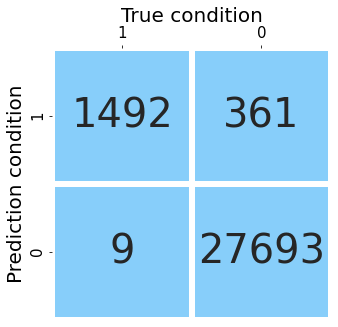

In [ ]:
make_heatmap(df_liver_contex_compare_train_doc_unique['Labels_KW'], df_liver_contex_compare_train_doc_unique['Labels_NER'], 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

## EMA NER model sentence count

### load table

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/EMA_labels/'
filename_test = 'EMA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test

test = pd.read_excel(filepath, sheet_name="Sheet1")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
# test.head()

540


In [ ]:
train_doc = test[test.Test_set == 0].Warnings_Precautions.values
print(len(train_doc))

431


### predict context

In [ ]:
df_liver_contex_compare_train_doc = compare_liver_context_pred(train_doc)

100%|██████████| 431/431 [04:32<00:00,  1.58it/s]


In [ ]:
# df_liver_contex_compare_train_doc.to_excel(dirpath_test + 'df_liver_contex_compare_EMA_NER_train_doc_20210331.xlsx')
df_liver_contex_compare_train_doc = pd.read_excel(dirpath_test + 'df_liver_contex_compare_EMA_NER_train_doc_20210331.xlsx')

In [ ]:
print(f"liver sentences: {len(df_liver_contex_compare_train_doc[df_liver_contex_compare_train_doc.Labels_KW == 1])}")
print(f"non-liver sentences: {len(df_liver_contex_compare_train_doc[df_liver_contex_compare_train_doc.Labels_KW == 0])}")

liver sentences: 1035
non-liver sentences: 15285


In [ ]:
df_liver_contex_compare_train_doc_unique = df_liver_contex_compare_train_doc.drop_duplicates(subset=['Sentences'])

print(f"total: {len(df_liver_contex_compare_train_doc_unique)}")
print(f"KW liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_KW == 1])}")
print(f"KW non-liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_KW == 0])}")

print(f"NER liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_NER == 1])}")
print(f"NER non-liver: {len(df_liver_contex_compare_train_doc_unique[df_liver_contex_compare_train_doc_unique.Labels_NER == 0])}")

total: 15104
KW liver: 996
KW non-liver: 14108
NER liver: 1159
NER non-liver: 13945


### get scores

In [ ]:
test_scores = score_getter(df_liver_contex_compare_train_doc_unique['Labels_KW'], df_liver_contex_compare_train_doc_unique['Labels_NER'])

print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:975, TN:13924, FP:184, FN:21
sensitivity:0.979, specificity:0.987, PPV:0.841, NPV:0.998, F1:0.905
ACC:0.986, ACC_bal:0.983, MCC:0.901
AUC:0.983


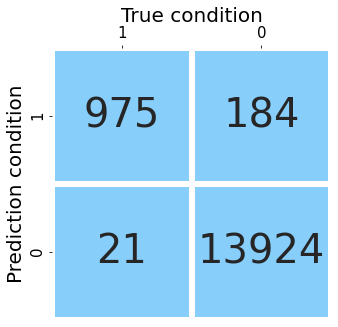

In [ ]:
make_heatmap(df_liver_contex_compare_train_doc_unique['Labels_KW'], df_liver_contex_compare_train_doc_unique['Labels_NER'], 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

## Unbalanced sent cls model prediction

In [ ]:
# Defining some key variables that will be used later on in the training
# USE_GPU = True

MAX_LEN = 128
BATCH_SIZE = 16
N_EPOCHS = 3
LEARNING_RATE = 2e-05
EPS = 1e-8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
WEIGHT_DECAY = False
SEED_VAL = 97

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# # load tokenizer from a trained model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# load the trained FDA sentence classification model 
# model_SentClf = BertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/DILI_BERT/FDA_labels/imbalanced_training/checkpoint-4398/')
# model_SentClf = BertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/DILI_BERT/CVs_permutations/model/checkpoint-4182/')
model_SentClf = BertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/DILI_BERT/FDA_labels/imbalanced_training/20211012/checkpoint-4299/')
# model_SentClf = BertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/DILI_BERT/FDA_labels/imbalanced_training/20211012-2/checkpoint-4299/')

# Copy the model to the GPU.
model_SentClf.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
!ls '/content/gdrive/My Drive/DILI_BERT/FDA_labels/imbalanced_training/20211012-2/checkpoint-4299'

config.json   pytorch_model.bin  scheduler.pt	     training_args.bin
optimizer.pt  rng_state.pth	 trainer_state.json


### predict on FDA test docs

#### checkpoint-4299-2

In [ ]:
print(len(test_doc))
print(len(test_label))

150
150


In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

100%|██████████| 150/150 [02:18<00:00,  1.08it/s]

TP:37, TN:106, FP:4, FN:3
sensitivity:0.925, specificity:0.964, PPV:0.902, NPV:0.972, F1:0.914
ACC:0.953, ACC_bal:0.944, MCC:0.882
AUC:0.944


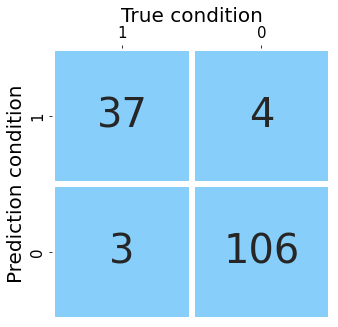

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

#### checkpoint-4299

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/FDA_labels/'
filename_test = 'FDA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test
test = pd.read_excel(filepath, sheet_name="test_set")
test['Boxed_Warning'] = test['Boxed_Warning'].apply(normalize_text)
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
test['Adverse_Reactions'] = test['Adverse_Reactions'].apply(normalize_text)
print(len(test))
test.head()

In [ ]:
print(len(test_doc))
print(len(test_label))

150
150


In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

100%|██████████| 150/150 [02:26<00:00,  1.02it/s]

TP:36, TN:104, FP:6, FN:4
sensitivity:0.900, specificity:0.945, PPV:0.857, NPV:0.963, F1:0.878
ACC:0.933, ACC_bal:0.923, MCC:0.833
AUC:0.923


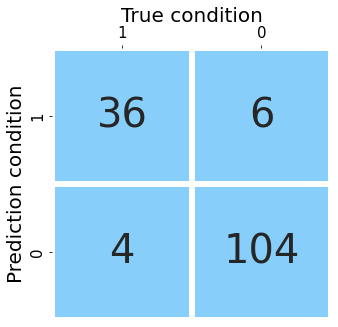

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

In [ ]:
test['WP_SentClf_pred_label'] = doc_pred_labels
test.to_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_20211013.xlsx')

In [ ]:
df_test_fda = test[test['WP_SentClf_pred_label']!=test['WP_true_label_updated']].drop(columns=['Compound_name','LabelSection','vDILIConcern','Boxed_Warning','Adverse_Reactions','Test_set','multiclass_true_label_updated','multiclass_pred_label','in_EMA_training'])
df_test_fda

In [ ]:
df_test_fda.to_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_diff_20211013.xlsx')

In [ ]:
df_test_fda = pd.read_excel('/content/gdrive/My Drive/DILI_BERT/FDA_labels/FDA_SentClf_test_doc_checked_diff_20211013.xlsx')
df_test_fda

,Unnamed: 0,LTKBID,Warnings_Precautions,WP_true_label_updated,WP_pred_label,WP_SentClf_pred_label
0,70,LT01708,use of propofol has been associated with both...,0,1,1
1,77,LT02203,peripheral neuropathy was common . patients t...,1,1,0
2,86,LT01169,the majority of subjects (98%) receiving fuze...,1,1,0
3,89,LT00341,"concomitant use of benzodiazepines, including...",1,1,0
4,91,LT00416,"minocycline hydrochloride capsules, like othe...",1,1,0
5,92,LT01344,the effects of ethacrynic acid on electrolyte...,0,1,1
6,95,LT02046,"rarely, the rapid onset of severe hyponatremi...",0,1,1
7,97,LT00129,"fatalities due to severe hypotension, hypogly...",0,0,1
8,105,LT01730,patients exhibiting the following conditions ...,0,0,1
9,119,LT00494,fomepizole should not be given undiluted or b...,0,0,1


In [ ]:
i=2
result = AI_model_inspection(df_test_fda.Warnings_Precautions[i:i+1])
result

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


,doc_id,liver_sentences,liver_sent_labels
0,0,hypersensitivity reactions have occurred in <1...,1


In [ ]:
result.liver_sentences[0]

'hypersensitivity reactions have occurred in <1% of subjects studied and have included combinations of: rash, fever, nausea and vomiting, chills, rigors, hypotension, and/or elevated serum liver transaminases.'

In [ ]:
results = doc_Clf_sent_direct_inspection(df_test_fda.Warnings_Precautions.values)
results

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


,doc_id,liver_sentences,liver_sent_labels
0,0,use of propofol has been associated with both...,1
1,0,the syndrome is characterized by severe metabo...,1
2,0,the syndrome has also been reported following ...,1
3,0,apnea requiring ventilatory support often occu...,1
4,0,very rarely the use of propofol may be associa...,1
...,...,...,...
180,9,"minor allergic reactions (mild rash, eosinophi...",1
181,9,"in rats, fomepizole (110 mg/kg) administered o...",1
182,9,fomepizole should not be given undiluted or by...,1
183,9,venous irritation and phlebosclerosis were not...,1


In [ ]:
results.to_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_diff_sentences_20211013.xlsx')

####checkpoint-4182

In [ ]:
print(len(test_doc))
print(len(test_label))

150
150


In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)

100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:38, TN:105, FP:5, FN:2
sensitivity:0.950, specificity:0.955, PPV:0.884, NPV:0.981, F1:0.916
ACC:0.953, ACC_bal:0.952, MCC:0.885
AUC:0.952


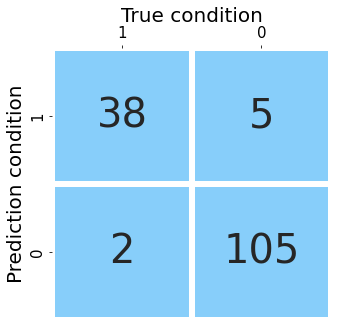

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

####checkpoint-4398

In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)

100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)

print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:36, TN:102, FP:8, FN:4
sensitivity:0.900, specificity:0.927, PPV:0.818, NPV:0.962, F1:0.857
ACC:0.920, ACC_bal:0.914, MCC:0.804
AUC:0.914


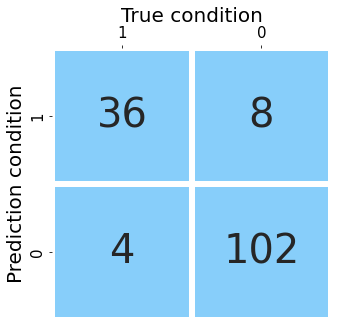

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

### predict on EMA validation docs

#### checkpoint-4299-2

In [ ]:
print(len(test_doc))
print(len(test_label))

175
175


In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

100%|██████████| 175/175 [01:38<00:00,  1.78it/s]

TP:33, TN:132, FP:7, FN:3
sensitivity:0.917, specificity:0.950, PPV:0.825, NPV:0.978, F1:0.868
ACC:0.943, ACC_bal:0.933, MCC:0.834
AUC:0.933


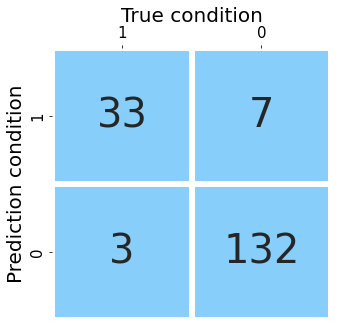

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

#### checkpoint-4299

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/EMA_labels/'
filename_test = 'EMA_label_train_test_doc_checked_trimmed_20210215.xlsx'
filepath = dirpath_test + filename_test
test = pd.read_excel(filepath, sheet_name="not_in_FDA_training")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
test.head()

In [ ]:
print(len(test_doc))
print(len(test_label))

175
175


In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)
test_scores = score_getter(test_label, doc_pred_labels)
print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

100%|██████████| 175/175 [01:44<00:00,  1.68it/s]

TP:32, TN:132, FP:7, FN:4
sensitivity:0.889, specificity:0.950, PPV:0.821, NPV:0.971, F1:0.853
ACC:0.937, ACC_bal:0.919, MCC:0.814
AUC:0.919


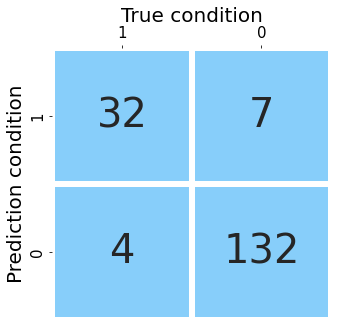

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

In [ ]:
test['WP_SentClf_pred_label'] = doc_pred_labels
test.to_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_cross_agency_20211013.xlsx')

In [ ]:
test.head()

,LTKBID,eMC_LabelSection2,Warnings_Precautions,Adverse_Reactions,Test_set,WP_true_label_updated,WP_pred_label,multiclass_true_label_updated,multiclass_pred_label,in_FDA_training,WP_SentClf_pred_label
0,LT00046,Warnings and precautions,patients with rare hereditary problems of gala...,the following adverse reactions are classified...,0,1,1,2,2,0,1
1,LT00671,Warnings and precautions,careful monitoring during dronedarone administ...,summary of the safety profile assessment of in...,0,1,1,2,2,0,1
2,LT01525,Warnings and precautions,the selection of meropenem to treat an individ...,summary of the safety profile in a review of 4...,0,1,1,2,2,0,0
3,LT01097,Warnings and precautions,hypersensitivity caution should be used in pre...,summary of safety profile the safety profile o...,0,1,1,2,2,0,1
4,LT01181,Warnings and precautions,oxaliplatin should only be used in specialized...,summary of the safety profile the most frequen...,0,1,1,2,2,0,1


In [ ]:
df_test_fda_cross = test[test['WP_SentClf_pred_label']!=test['WP_true_label_updated']].drop(columns=['eMC_LabelSection2','Adverse_Reactions','Test_set','multiclass_true_label_updated','multiclass_pred_label','in_FDA_training'])
df_test_fda_cross

In [ ]:
df_test_fda_cross.to_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_cross_agency_diff_20211013.xlsx')

In [ ]:
df_test_fda_cross = pd.read_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_cross_agency_diff_20211013.xlsx')
df_test_fda_cross

,Unnamed: 0,LTKBID,Warnings_Precautions,WP_true_label_updated,WP_pred_label,WP_SentClf_pred_label
0,2,LT01525,the selection of meropenem to treat an individ...,1,1,0
1,8,LT00577,severe acute exacerbations of chronic hepatiti...,1,1,0
2,28,LT02018,dose limiting toxicities dose limiting toxicit...,1,1,0
3,30,LT01581,the use of nabumetone with concomitant nsaids ...,0,1,1
4,32,LT01267,non-infectious pneumonitis non-infectious pneu...,0,1,1
5,34,LT01723,aortic stenosis quinapril should be used in ca...,0,1,1
6,35,LT01466,the use of campto should be confined to units ...,0,1,1
7,73,LT01708,diprivan 1% should be given by those trained i...,0,0,1
8,102,LT00399,fludrocortisone acetate is a potent mineraloco...,0,1,1
9,146,LT00416,minocycline should be used with caution in pat...,1,1,0


In [ ]:
i=9
result = AI_model_inspection(df_test_fda.Warnings_Precautions[i:i+1])
result

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


,doc_id,liver_sentences,liver_sent_labels
0,0,"in addition, hepatic enzymes and white blood c...",0


In [ ]:
result.liver_sentences[0]

'in addition, hepatic enzymes and white blood cell counts should be monitored during treatment, as transient increases in serum transaminase concentrations and eosinophilia have been noted with repeated fomepizole dosing.'

In [ ]:
results = doc_Clf_sent_direct_inspection(df_test_fda_cross.Warnings_Precautions.values)
results

100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


,doc_id,liver_sentences,liver_sent_labels
0,0,hypersensitivity reactions as with all beta-la...,1
1,0,antibiotic-associated colitis antibiotic-assoc...,1
2,0,seizures seizures have infrequently been repor...,1
3,0,hepatic function monitoring hepatic function s...,1
4,0,direct antiglobulin test (coombs test) serocon...,1
...,...,...,...
145,10,some studies concluded in an increased risk of...,1
146,10,when selegiline is added to the maximum tolera...,1
147,10,levodopa should be reduced by about 10 to 30% ...,1
148,10,"when an optimum dose of levodopa is reached, a...",1


In [ ]:
results.to_excel(dirpath_test + 'FDA_SentClf_test_doc_checked_cross_agency_diff_sentences_20211013.xlsx')

####checkpoint-4182

####checkpoint-4398

In [ ]:
doc_pred_labels = doc_Clf_sent_direct(test_doc)

100%|██████████| 175/175 [01:44<00:00,  1.68it/s]


In [ ]:
test_scores = score_getter(test_label, doc_pred_labels)

print(f'TP:{test_scores.tp}, TN:{test_scores.tn}, FP:{test_scores.fp}, FN:{test_scores.fn}')
print(f'sensitivity:{test_scores.sensitivity:.3f}, specificity:{test_scores.specificity:.3f}, PPV:{test_scores.PPV:.3f}, NPV:{test_scores.NPV:.3f}, F1:{test_scores.f1:.3f}')
print(f'ACC:{test_scores.acc:.3f}, ACC_bal:{test_scores.acc_bal:.3f}, MCC:{test_scores.mcc:.3f}')
print(f'AUC:{test_scores.auc:.3f}')

TP:35, TN:128, FP:11, FN:1
sensitivity:0.972, specificity:0.921, PPV:0.761, NPV:0.992, F1:0.854
ACC:0.931, ACC_bal:0.947, MCC:0.820
AUC:0.947


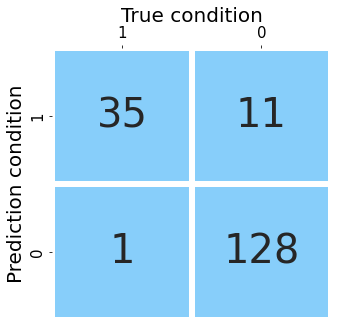

In [ ]:
make_heatmap(test_label, doc_pred_labels, 
             fig_name='liver context prediction', figsize=(5,5),
             fontsize=20, annot_kws={"size":40}, categories=[0, 1])

## Compare AI and hybrid AI models

In [ ]:
dirpath_test = '/content/gdrive/My Drive/DILI_BERT/FDA_labels/'
filename_test = 'Comparison_hybridAI_AI_20210930.xlsx'
filepath = dirpath_test + filename_test

In [ ]:
test = pd.read_excel(filepath, sheet_name="combined")
test['Warnings_Precautions'] = test['Warnings_Precautions'].apply(normalize_text)
print(len(test))
test.head()

8


,LTKBID,Warnings_Precautions,WP_true_label_updated,WP_NER_pred_label,WP_hybrid_pred_label,better
0,LT01387,traceability in order to improve traceability ...,0,1,0,HybridAI
1,LT01113,medical management. the pump should only be im...,0,1,0,HybridAI
2,LT01256,skin and bone lesions that resemble clinical ...,0,1,0,HybridAI
3,LT02046,"rarely, the rapid onset of severe hyponatremi...",0,1,0,HybridAI
4,LT01844,patients with major depressive disorder (mdd)...,0,1,0,HybridAI


In [ ]:
test_doc = test.Warnings_Precautions.to_list()

In [ ]:
def AI_model_inspection(documents):
    liver_sentences_all, labels_all, doc_ids_all = [], [], []
    id=0
    for doc in tqdm(documents):
        sentences = sent_tokenize(doc)
        sent_labels = [0] * len(sentences)
        # context prediction and get liver sentence indexes
        liver_sent_idx = []
        for idx, sentence in enumerate(sentences):
            context_pred = model_NER_predict_single_sentence(sentence, tokenizer, model_NER)
            if context_pred[0] == 1:
                liver_sent_idx.append(idx)
        # sentence prediction for liver sentences (if any)
        if liver_sent_idx:
            liver_sentences = [sentences[i] for i in liver_sent_idx]
            liver_sent_labels = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
            doc_id = [id]*len(liver_sentences)

            liver_sentences_all.extend(liver_sentences)
            labels_all.extend(liver_sent_labels)
            doc_ids_all.extend(doc_id)

        id += 1
    df_result = pd.DataFrame({
                'doc_id': doc_ids_all,
                'liver_sentences': liver_sentences_all,
                'liver_sent_labels': labels_all,
            })
    return df_result

In [ ]:
def Hybrid_AI_model_inspection(documents):
    doc_labels = []
    liver_sentences_all, labels_all, doc_ids_all = [], [], []    
    id = 0
    for doc in tqdm(documents):
        # prepare sentences
        liver_sentences = []
        # tokenize liver-related sentences
        sent_tokens = sent_tokenize(doc)
        for sent in sent_tokens:
            kw_positive = any(keyword in word_tokenize(sent) for keyword in keywords_positive)
            kw_negative = any(keyword in word_tokenize(sent) for keyword in keywords_negative)
            if kw_positive == True and kw_negative == False:
                liver_sentences.append(sent)  

        if len(liver_sentences) == 0:
            doc_label = [0]
        else:
            liver_sent_labels = model_SentClf_predict_batch(liver_sentences, tokenizer, model_SentClf)
            doc_label = [1 if np.sum(liver_sent_labels) > 0 else 0]
            doc_id = [id]*len(liver_sent_labels)

            liver_sentences_all.extend(liver_sentences)
            labels_all.extend(liver_sent_labels)
            doc_ids_all.extend(doc_id)

        id += 1
        doc_labels.append(doc_label[0])
    df_result = pd.DataFrame({
        'doc_id': doc_ids_all,
        'liver_sentences': liver_sentences_all,
        'liver_sent_labels': labels_all,
    })
    return doc_labels, df_result

#### AI model inspection

In [ ]:
doc_pred_labels = doc_Clf(test_doc)
doc_pred_labels

100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


[1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
df_result = AI_model_inspection(test_doc)

100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


In [ ]:
df_result

,doc_id,liver_sentences,liver_sent_labels
0,0,hepatitis b reactivation reactivation of hepat...,0
1,0,for patients who test positive for hepatitis b...,0
2,0,rare post-marketing cases of hepatosplenic t-c...,0
3,0,some of these hepatosplenic t-cell lymphomas w...,1
4,0,a risk for the development of hepatosplenic t-...,0
5,1,"with oral baclofen, rare cases of elevated sgo...",1
6,2,cysteamine has been associated with reversible...,1
7,2,monitor white blood cell counts and alkaline p...,0
8,2,leukopenia and/or elevated alkaline phosphatas...,0
9,3,the risk of hypokalemia is increased when larg...,0


In [ ]:
any(keyword in df_result.liver_sentences[0] for keyword in keywords_positive)

True

In [ ]:
any(keyword in word_tokenize(df_result.liver_sentences[0]) for keyword in keywords_negative)

False

In [ ]:
df_result.to_excel(os.path.join(dirpath_test, 'sentence_inspection_AI_model_20210930.xlsx'))

### hybrid AI model inspection

In [ ]:
doc_labels_hybrid, df_result_hybrid = Hybrid_AI_model_inspection(test_doc)

100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


In [ ]:
doc_labels_hybrid

[0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df_result_hybrid

,doc_id,liver_sentences,liver_sent_labels
0,0,hepatitis b reactivation reactivation of hepat...,0
1,0,for patients who test positive for hepatitis b...,0
2,3,the risk of hypokalemia is increased when larg...,0
3,3,these hazards include fetal or neonatal jaundi...,0
4,3,"in general, dose selection for an elderly pati...",0
5,3,the risk of hypokalemia is increased when larg...,0
6,4,trimipramine maleate capsules should be used w...,0
7,4,"clinical circumstances, some of which may be m...",0
8,4,trimipramine maleate capsules should be used w...,0
9,5,in a similar study attempting to replicate thi...,0


In [ ]:
df_result_hybrid.to_excel(os.path.join(dirpath_test, 'sentence_inspection_Hybrid_AI_model_20210930.xlsx'))

### Sentence classifier inspection

In [ ]:
def doc_Clf_sent_direct_inspection(documents):
    doc_ids_all, sentences_all, labels_all = [], [], []
    id=0
    for doc in tqdm(documents):
        sents_positive = []

        sentences = sent_tokenize(doc)
        sent_labels = model_SentClf_predict_batch(sentences, tokenizer, model_SentClf)

        for idx, label in enumerate(sent_labels):
            if label == 1:
                sents_positive.append(sentences[idx])

        sents_positive_labels = [1]*len(sents_positive)
        doc_id = [id]*len(sents_positive)

        sentences_all.extend(sents_positive)
        labels_all.extend(sents_positive_labels)
        doc_ids_all.extend(doc_id)
        id += 1

    df_result = pd.DataFrame({
            'doc_id': doc_ids_all,
            'liver_sentences': sentences_all,
            'liver_sent_labels': labels_all,
        })
    return df_result 

## CAMDA-2022

### load tables

In [ ]:
!ls '/content/gdrive/My Drive/CAMDA2022'

CAMDA2022_2.xlsx  CAMDA2022.xlsx  Data1_pred.xlsx  Data2_pred.xlsx


In [ ]:
# set path to directory containing the pdf files for text mining
dirpath_test = '/content/gdrive/My Drive/CAMDA2022'

# filename_test = 'test_doc_multiclass_20200830.pkl'
filename_test = 'CAMDA2022_2.xlsx'

filepath = os.path.join(dirpath_test, filename_test)

In [ ]:
test_1 = pd.read_excel(filepath, sheet_name="Data1")
test_2 = pd.read_excel(filepath, sheet_name="Data2")
test_1.head()

,CAID,Description
0,1,BACKGROUND AND Overweight in adolescents may ...
1,2,Indocyanine green [ICG] testing of 55 patients...
2,3,Nitric oxide is a vasodilator tonically secret...
3,4,"Two patients, 77 and 62 year old men with rena..."
4,5,Among 18 patients with relapsed B cell lymphom...


In [ ]:
test_1['Description'] = test_1['Description'].apply(lowercase_text)
test_1.head()

,CAID,Description
0,1,background and overweight in adolescents may h...
1,2,indocyanine green [icg] testing of 55 patients...
2,3,nitric oxide is a vasodilator tonically secret...
3,4,"two patients, 77 and 62 year old men with rena..."
4,5,among 18 patients with relapsed b cell lymphom...


In [ ]:
test_2['Description'] = test_2['Description'].apply(lowercase_text)
test_2.head()

,CAID,Description
0,14001,among 4921 patients with deep venous thrombosi...
1,14002,a 42-year-old man presented with impaired nasa...
2,14003,primary sclerosing cholangitis (psc) is charac...
3,14004,description of 6 patients with a myeloprolifer...
4,14005,intravenous infusion of magnesium sulfate prev...


### predict

In [ ]:
test_doc_1 = test_1.Description.values
test_doc_2 = test_2.Description.values

In [ ]:
print(f"test_doc_1: {len(test_doc_1)}")
print(f"test_doc_2: {len(test_doc_2)}")

test_doc_1: 14000
test_doc_2: 11030


In [ ]:
# AI
doc_1_pred_labels_AI = doc_Clf(test_doc_1)
# doc_1_pred_labels_AI
test_1['pred_AI'] = doc_1_pred_labels_AI

100%|██████████| 14000/14000 [29:34<00:00,  7.89it/s]


In [ ]:
# hybrid AI
doc_1_pred_labels_hybrid = doc_Clf_HybridAI(test_doc_1)
# doc_1_pred_labels_hybrid
test_1['pred_hybridAI'] = doc_1_pred_labels_hybrid

100%|██████████| 14000/14000 [11:27<00:00, 20.36it/s]


In [ ]:
# keywords only
doc_1_pred_labels_KWs = doc_Clf_KWs(test_doc_1)
# doc_1_pred_labels_KWs
test_1['pred_keywords'] = doc_1_pred_labels_KWs

100%|██████████| 14000/14000 [00:01<00:00, 13072.44it/s]


In [ ]:
test_1.to_excel(os.path.join(dirpath_test, "Data1_pred_2.xlsx"))

In [ ]:
# AI
doc_2_pred_labels_AI = doc_Clf(test_doc_2)
# doc_2_pred_labels_AI
test_2['pred_AI'] = doc_2_pred_labels_AI

100%|██████████| 11030/11030 [21:58<00:00,  8.37it/s]


In [ ]:
# hybrid AI
doc_2_pred_labels_hybrid = doc_Clf_HybridAI(test_doc_2)
# doc_2_pred_labels_hybrid
test_2['pred_hybridAI'] = doc_2_pred_labels_hybrid

100%|██████████| 11030/11030 [08:39<00:00, 21.22it/s]


In [ ]:
# keywords only
doc_2_pred_labels_KWs = doc_Clf_KWs(test_doc_2)
# doc_2_pred_labels_KWs
test_2['pred_keywords'] = doc_2_pred_labels_KWs

100%|██████████| 11030/11030 [00:00<00:00, 13182.46it/s]


In [ ]:
test_2.to_excel(os.path.join(dirpath_test, "Data2_pred_2.xlsx"))

In [ ]:
test_2_pred = pd.read_excel(os.path.join(dirpath_test, "Data2_pred.xlsx"))
test_2.head()

,CMID,Description,pred_AI,pred_hybridAI,pred_keywords
0,14001,commentary on the who global introspection met...,0,0,1
1,14002,hedgehog (hh) ligand production by ballooned h...,1,1,1
2,14003,clinicians continue to raise questions concern...,0,0,1
3,14004,primary liver cancer is the third most common ...,0,0,1
4,14005,overview of hepatotoxicity of antidiabetic med...,0,0,1
